In [2]:
# This notebook is used to analysis the noisy tubes by using MuonCalibration Ntuple for run456729
# latest data in folder cbnt_run456729_rawdata (15/03/2024)

# import the standard python module
import uproot
import pandas as pd
import sys,os, time, glob, re
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from scipy import stats
from tqdm.auto import tqdm
tqdm.pandas()

# import the custom python module
import muonfixedid, chamberlist_run3
import splitter_regions_Run2
import mdtCalib_functions

pd.set_option("mode.copy_on_write", True)

#Defined Constants
ACTIVE_TIME_WINDOW=1.3*(10**(-6))
ADC_CUT_VAL = 50
NOISE_THRESH=20000


In [3]:
# Load calibration ntuple for region 0120
dataFolder = 'cbnt_run456729_rawdata/'
listFile = os.listdir(dataFolder)
listFile.sort()

CHAMBER_TO_INPUT = {
    "BIS7A16": 'cbnt_run456729_rawdata/456729_fragments_reg0120_calibntuple24_dcsoff_0014_ntuple.root',  #region 120->BIS7A16; dcs_off??
    "??": 'cbnt_run456729_rawdata/456729_fragments_reg0120_calibntuple24_dcsoff_0011_ntuple.root',  #region 120
    "BIS7A02": 'cbnt_run456729_rawdata/456729_fragments_reg0113_calibntuple24_dcsoff_0011_ntuple.root', #region:113 "
    "bis7A06": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0115.ntuple.root',
    "BIS7A08": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0116.ntuple.root',
    "BIS7A10": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0117.ntuple.root',
    "BIS7A12": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0118.ntuple.root',
    "BIS7A14": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0119.ntuple.root'
}

#Constants
OPERATING_CHAMBER = "BIS7A02"
inputCalibNtuple = CHAMBER_TO_INPUT[OPERATING_CHAMBER]

# inputCalibNtuple="cbnt_run456729_rawdata/456729_fragments_reg0120_calibntuple24_dcsoff_0014_ntuple.root"
f = uproot.open(inputCalibNtuple)
treeName = "Segments"
tree = f[treeName]
df_all_chambers = tree.arrays()

run = inputCalibNtuple.split('/',1)[1][:6]        
region = int(inputCalibNtuple.split('0',1)[1][:3])       
      
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)

# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]]
print('process run %s, ,region %s, chamberList %s' % (run, region, chamberInRegion))
df_raw=ak.to_dataframe(tree.arrays(branchMapping['rawMdt']))

process run 456729, ,region 113, chamberList ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02']


In [4]:
#Defined all functions
def tube_id(row, chamber):
    # Grab the tube name
    tube_name = row['rawMdt_tubeInfo']  # Assuming the column name that holds the tube name is 'rawMdt_tubeInfo'
    # Split the tube name once and unpack into components
    _, ml_index, ly_index, tube_no = tube_name.split('-')
    # Convert string indices to integers
    ml_index = int(ml_index)
    ly_index = int(ly_index)
    tube_no = int(tube_no)
    
    
    unique_tube_id = ((ml_index - 1) * chamberlist_run3.MDTnTml(chamber, 1) +     #chamber is the operating chamber
                      (ly_index - 1) * chamberlist_run3.MDTnTly(chamber, ml_index) +
                      tube_no)
    return unique_tube_id

def noise_rate(df):
    df['Tube_ID']=df.apply(lambda row: tube_id(row, 'BIS7A16'),axis=1)    #creating a column Tube_Id by applying the function of tube_id
    tube_hits = df['rawMdt_tubeInfo'].value_counts()
    df['Tube_hits']=df['rawMdt_tubeInfo'].map(tube_hits)
    df['Noise_rate']=df['Tube_hits']/(ACTIVE_TIME_WINDOW*total_evts)  #returns the original dataframe with added columns of noise rate and tube id
    return df


def noisy_tubes(df):
    
    n_tubes=df[df['Noise_rate']>NOISE_THRESH]['rawMdt_tubeInfo']
    n_tb_list=n_tubes.unique().tolist()
    return n_tb_list              #returns list of tubes with noise rate over defined noise threshold

def df_raw_noisy(df,cut):         #DF for tubes that are noisy()
 
    df_raw_noise=df[df['rawMdt_tubeInfo'].isin(noisy_tubes_list)]
    return df_raw_noise
    
                #extract most noisy tube
def most_noisy():
    df=df_for_nt.sort_values(by=['Noise_rate'])
    return df['rawMdt_tubeInfo'].iloc[0]

def RawMdtplots(df,tube):

    fig,axes = plt.subplots(figsize=(8, 3), nrows = 1, ncols = 2)
    # fig,ax = plt.subplots(figsize=(8,6))
    # fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.4, hspace = 0.4)
    # fig.set_title(title, fontsize=20)
       
    adc_values = df.rawMdt_adc.values.astype(float)
    min_adc = -10
    max_adc = 350
    
    xadc, xbins, patch = axes[0].hist(adc_values,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    # mean = np.average(mdt_adc)
    # std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0].set_xlim(min_adc,max_adc)
    axes[0].set_xlabel('adc_values',fontsize=10)
    axes[0].set_ylabel('no of hits',fontsize=10)

    # axes[0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0].grid()
    axes[0].set_title(f'{tube}_rawADC')
    
    
    # # raw TDC spectrum
    tdc_values = df.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1700
    xtdc, xbins, patch = axes[1].hist(tdc_values,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1].set_xlim(min_tdc,max_tdc)
    axes[1].set_xlabel('tdcCount',fontsize=10)
    axes[1].set_ylabel('frequency',fontsize=10)
    # axes[1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1].grid()
    axes[1].set_title(f'{tube}_rawTDC')
    
    fig.patch.set_facecolor('white')
    fig.savefig('Adc_Tdc for %s'%(tube))
    plt.show()

def avg_adc_plot(df):  #Plots avg adc spectrum for all tubes after applying adc cut at 50
    min_adc = 50
    max_adc = 300

    plt.figure(figsize=(8, 5))  # Set the figure size
    plt.hist(df['Mean_adc'], bins=max_adc-min_adc)  # Create a histogram with 50 bins
    plt.xlabel('Avg_adc')  # Set the x-axis label
    plt.ylabel('Frequency')  # Set the y-axis label
    plt.title('1D Histogram of avg_adc for all tubes')  # Set the title
    plt.grid(True)  # Show grid
    plt.tight_layout()  # Adjust layout
    plt.show()

def plots(df,chamber,title):

    fig,axes = plt.subplots(figsize=(8, 3), nrows = 1, ncols = 2)
    # fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.4, hspace = 0.4)
    # fig.set_title(title, fontsize=20)
       
    # ADC count without cut
    mdt_adc = df.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    
    xadc, xbins, patch = axes[0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    # mean = np.average(mdt_adc)
    # std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0].set_xlim(min_adc,max_adc)
    axes[0].set_xlabel('adcCount',fontsize=10)
    # axes[0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0].grid()
    axes[0].set_title(f'{chamber,title}_rawADC')
    
    
    # # raw TDC spectrum
    mdt_tdc = df.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1].set_xlim(min_tdc,max_tdc)
    axes[1].set_xlabel('tdcCount',fontsize=10)
    # axes[1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1].grid()
    axes[1].set_title(f'{chamber,title}_rawTDC')
    
    fig.patch.set_facecolor('white')
    fig.savefig('Adc_Tdc for %s'%(chamber))
    plt.show()

In [24]:
# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])

                                                                    # Get the dataframe df_chamber for chamber BIS7A16
df_raw_chamber = df_raw[df_raw['rawMdt_station']==OPERATING_CHAMBER]
total_evts=len(df_all_chambers)
print(total_evts)    #print no of total events in ths op chamber
df_raw_chamber       #df_chamber with all raw values   

27971


rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 35   4307.955078   1780.171753   6535.729980   
      1                 37   4307.567871   1780.585693   6339.417480   
      2                 35   4307.538086   1780.617432   6324.316406   
      3                 67   4307.508301   1780.649292   6309.215820   
      4                 35   4307.478516   1780.681152   6294.114746   
...                    ...           ...           ...           ...   
27970 23                35   4230.391602   1746.779175   6898.238281   
      24                35   4230.391602   1746.779175   6898.238281   
      25               228   4228.784668   1748.498291   6082.786621   
      26                36   4228.188965   1749.135132   5780.767578   
      27               157   4192.552734   1733.373657   6090.376953   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649653           151         839  BIS7A02-2-4-54   
      1          24649640           151         956  BIS7A02-2-4-41   
      2          24649639           151         835  BIS7A02-2-4-40   
      3          24649638           151         717  BIS7A02-2-4-39   
      4          24649637           151         607  BIS7A02-2-4-38   
...                   ...           ...         ...             ...   
27970 23         24649165           218         214  BIS7A02-1-4-78   
      24         24649165           218        1555  BIS7A02-1-4-78   
      25         24649111           218          95  BIS7A02-1-4-24   
      26         24649091           218        1067   BIS7A02-1-4-4   
      27         24648728           218          26  BIS7A02-1-1-25   

               rawMdt_station rawMdt_type  
entry subentry                             
0     0               BIS7A02         BIS  
      1               BIS7A02         BIS  
      2               BIS7A02         BIS  
      3               BIS7A02         BIS  
      4               BIS7A02         BIS  
...                       ...         ...  
27970 23              BIS7A02         BIS  
      24              BIS7A02         BIS  
      25              BIS7A02         BIS  
      26              BIS7A02         BIS  
      27              BIS7A02         BIS  

[480445 rows x 10 columns]

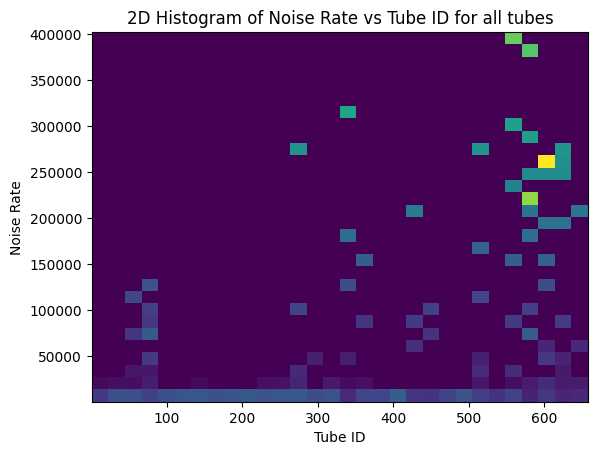

In [25]:
                          # Plot 2D histogram noiseRate vs TubeId by using df_chamber 
df_noise_rate=noise_rate(df_raw_chamber)  #DF with tube_hits, noise_rate, Tube_id

fig, ax = plt.subplots()    #create subplot (1)

hist=ax.hist2d(df_noise_rate['Tube_ID'],df_noise_rate['Noise_rate'], bins=30)
ax.set_xlabel("Tube ID")
ax.set_ylabel("Noise Rate")
plt.title('2D Histogram of Noise Rate vs Tube ID for all tubes')

plt.show()
print(df_noise_rate)

In [27]:
                                # Get the noisy tube list by using cut 20k
noisy_tubes_list=noisy_tubes(df_noise_rate)  #print list of tubes with noise rate over 20k 
print(noisy_tubes_list)

df_for_nt=df_raw_noisy(df_noise_rate,ADC_CUT_VAL)  # DF for tubes that are noisy
df_for_nt

['BIS7A02-2-4-54', 'BIS7A02-2-4-41', 'BIS7A02-2-4-40', 'BIS7A02-2-4-39', 'BIS7A02-2-4-38', 'BIS7A02-2-4-37', 'BIS7A02-2-4-31', 'BIS7A02-2-4-30', 'BIS7A02-2-4-23', 'BIS7A02-2-4-19', 'BIS7A02-2-4-18', 'BIS7A02-2-4-17', 'BIS7A02-2-4-3', 'BIS7A02-2-4-1', 'BIS7A02-2-4-97', 'BIS7A02-2-4-67', 'BIS7A02-2-4-66', 'BIS7A02-2-4-65', 'BIS7A02-2-4-64', 'BIS7A02-2-4-63', 'BIS7A02-2-4-60', 'BIS7A02-2-4-59', 'BIS7A02-2-3-98', 'BIS7A02-2-3-97', 'BIS7A02-2-3-68', 'BIS7A02-2-3-67', 'BIS7A02-2-2-97', 'BIS7A02-2-2-67', 'BIS7A02-2-1-98', 'BIS7A02-2-1-97', 'BIS7A02-2-1-69', 'BIS7A02-2-1-68', 'BIS7A02-2-1-67', 'BIS7A02-1-4-78', 'BIS7A02-1-4-72', 'BIS7A02-1-4-68', 'BIS7A02-1-1-70', 'BIS7A02-1-1-69', 'BIS7A02-1-1-68', 'BIS7A02-2-4-68', 'BIS7A02-2-4-61', 'BIS7A02-2-4-56', 'BIS7A02-2-4-43', 'BIS7A02-2-3-66', 'BIS7A02-2-3-62', 'BIS7A02-2-1-96', 'BIS7A02-1-1-74', 'BIS7A02-1-1-67', 'BIS7A02-1-1-64', 'BIS7A02-2-4-28', 'BIS7A02-2-4-24', 'BIS7A02-2-4-5', 'BIS7A02-2-3-1', 'BIS7A02-2-1-36', 'BIS7A02-2-1-1', 'BIS7A02-2-4-9

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 35   4307.955078   1780.171753   6535.729980   
      1                 37   4307.567871   1780.585693   6339.417480   
      2                 35   4307.538086   1780.617432   6324.316406   
      3                 67   4307.508301   1780.649292   6309.215820   
      4                 35   4307.478516   1780.681152   6294.114746   
...                    ...           ...           ...           ...   
27970 20                65   4284.177246   1769.685303   6732.068848   
      21                35   4272.973145   1763.709961   7177.560547   
      22               118   4272.080078   1764.665039   6724.531738   
      23                35   4230.391602   1746.779175   6898.238281   
      24                35   4230.391602   1746.779175   6898.238281   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649653           151         839  BIS7A02-2-4-54   
      1          24649640           151         956  BIS7A02-2-4-41   
      2          24649639           151         835  BIS7A02-2-4-40   
      3          24649638           151         717  BIS7A02-2-4-39   
      4          24649637           151         607  BIS7A02-2-4-38   
...                   ...           ...         ...             ...   
27970 20         24649410           218         865  BIS7A02-2-2-67   
      21         24649312           218         836  BIS7A02-2-1-97   
      22         24649282           218         751  BIS7A02-2-1-67   
      23         24649165           218         214  BIS7A02-1-4-78   
      24         24649165           218        1555  BIS7A02-1-4-78   

               rawMdt_station rawMdt_type  Tube_ID  Tube_hits     Noise_rate  
entry subentry                                                                
0     0               BIS7A02         BIS      606       9379  257931.979000  
      1               BIS7A02         BIS      593       5762  158460.823435  
      2               BIS7A02         BIS      592       8044  221218.129766  
      3               BIS7A02         BIS      591      10612  291840.725147  
      4               BIS7A02         BIS      590       7831  215360.414495  
...                       ...         ...      ...        ...            ...  
27970 20              BIS7A02         BIS      427       7783  214040.365983  
      21              BIS7A02         BIS      361       5642  155160.702156  
      22              BIS7A02         BIS      331      11316  311201.436653  
      23              BIS7A02         BIS      276       9812  269839.916617  
      24              BIS7A02         BIS      276       9812  269839.916617  

[347342 rows x 13 columns]

In [34]:
most_noisy_tube=str(most_noisy())   #extracts the most noisy tube
print(most_noisy_tube)
df_most_nt=df_for_nt[df_for_nt['rawMdt_tubeInfo']==most_noisy_tube]  
print('The most noisy tube is',{df_most_nt['rawMdt_tubeInfo'].iloc[0]},{df_most_nt['Tube_ID'].iloc[0]})
print(df_most_nt)


# # df_most_nt['rawMdt_adc'].min() #max=267 min=0
# df_most_nt['rawMdt_tdc'].min()    #max=1663  min=0

BIS7A02-2-4-47
The most noisy tube is {'BIS7A02-2-4-47'} {599}
                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
15    11               153   4307.746582   1780.394653   6430.023438   
131   1                  0   4307.746582   1780.394653   6430.023438   
154   1                 36   4307.746582   1780.394653   6430.023438   
179   2                125   4307.746582   1780.394653   6430.023438   
227   18                36   4307.746582   1780.394653   6430.023438   
...                    ...           ...           ...           ...   
27680 40                37   4307.746582   1780.394653   6430.023438   
27704 1                 37   4307.746582   1780.394653   6430.023438   
27777 17               162   4307.746582   1780.394653   6430.023438   
27884 7                166   4307.746582   1780.394653   6430.023438   
27892 1                 36   4307.746582   1780.394653   6430.023438   



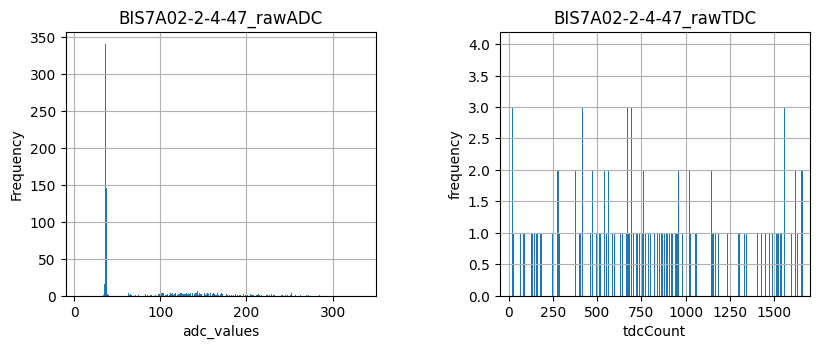

In [66]:
RawMdtplots(df_most_nt,most_noisy_tube) #Plots the ADC and TDC spectrum for the most noisy tube 

In [35]:
# Get the dataframe df_adcCut by apply ADC cut > 50 on ddf_noise_rate
df_adcCut = df_noise_rate[df_noise_rate['rawMdt_adc']>=ADC_CUT_VAL]
df_adcCut

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     3                 67   4307.508301   1780.649292   6309.215820   
      7                 61   4307.240723   1780.935791   6173.307129   
      10                73   4306.883301   1781.317871   5992.095703   
      12                63   4306.437012   1781.795410   5765.581055   
      14               156   4294.518555   1776.584106   5848.649414   
...                    ...           ...           ...           ...   
27970 19               159   4294.994629   1776.074707   6090.265137   
      20                65   4284.177246   1769.685303   6732.068848   
      22               118   4272.080078   1764.665039   6724.531738   
      25               228   4228.784668   1748.498291   6082.786621   
      27               157   4192.552734   1733.373657   6090.376953   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     3          24649638           151         717  BIS7A02-2-4-39   
      7          24649629           151         358  BIS7A02-2-4-30   
      10         24649617           151         601  BIS7A02-2-4-18   
      12         24649602           151         860   BIS7A02-2-4-3   
      14         24649480           151        1289   BIS7A02-2-3-9   
...                   ...           ...         ...             ...   
27970 19         24649496           218          78  BIS7A02-2-3-25   
      20         24649410           218         865  BIS7A02-2-2-67   
      22         24649282           218         751  BIS7A02-2-1-67   
      25         24649111           218          95  BIS7A02-1-4-24   
      27         24648728           218          26  BIS7A02-1-1-25   

               rawMdt_station rawMdt_type  Tube_ID  Tube_hits     Noise_rate  
entry subentry                                                                
0     3               BIS7A02         BIS      591      10612  291840.725147  
      7               BIS7A02         BIS      582      13966  384079.114907  
      10              BIS7A02         BIS      570      14613  401872.268806  
      12              BIS7A02         BIS      555       1279   35173.792637  
      14              BIS7A02         BIS      465        134    3685.135429  
...                       ...         ...      ...        ...            ...  
27970 19              BIS7A02         BIS      481        178    4895.179898  
      20              BIS7A02         BIS      427       7783  214040.365983  
      22              BIS7A02         BIS      331      11316  311201.436653  
      25              BIS7A02         BIS      222        188    5170.190004  
      27              BIS7A02         BIS       25        179    4922.680909  

[205561 rows x 13 columns]

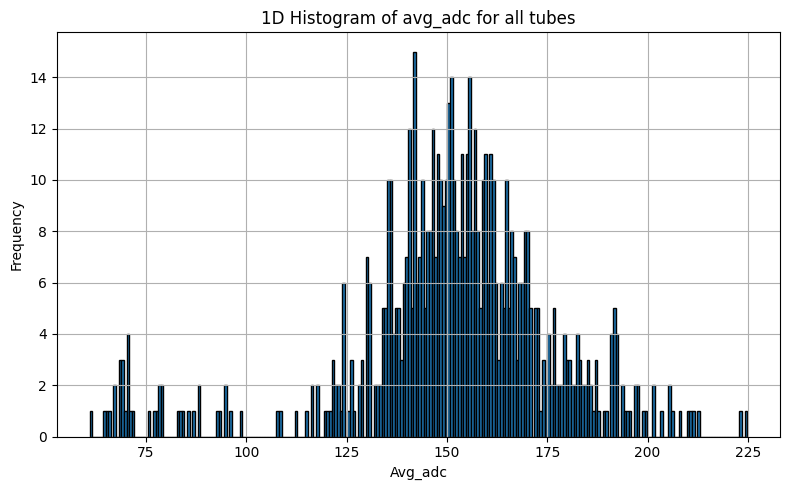

In [49]:
def df_mean_adc(df):
    grouped_data = df.groupby('Tube_ID')['rawMdt_adc'].mean()  #Mean of adc values for each tube
    df_mean_adc = grouped_data.reset_index()
    df_mean_adc.columns = ['Tube_ID', 'Mean_adc'] #just renames the columns 
    return df_mean_adc
df_mean_adc_all_tubes=df_mean_adc(df_adcCut)
# df_mean_adc_most_nt=df_mean_adc(df_most_nt)
mean_adc_hist_for_all_tubes=avg_adc_plot(df_mean_adc_all_tubes) #plots mean adc 1D histogram for all tubes after applying adc cut at 50
# mean_adc_hist_for_most_nt=avg_adc_plot(df_mean_adc_most_nt)

# df_mean_adc['Mean_adc'].max() #257.1311475409836
# df_mean_adc['Mean_adc'].min() #58

In [67]:
def df_mean_adc(df):
    grouped_data = df.groupby('Tube_ID')['rawMdt_adc'].mean()  #Mean of adc values for each tube
    df_mean_adc = grouped_data.reset_index()
    df_mean_adc.columns = ['Tube_ID', 'Mean_adc'] #just renames the columns 
    return df_mean_adc
df_mean_adc_before_adcCut=df_mean_adc(df_noise_rate)

mean_adc_hist_before_adcCut=avg_adc_plot(df_mean_adc_before_adcCut) #plots mean adc 1D histogram for all tubes after applying adc cut at 50


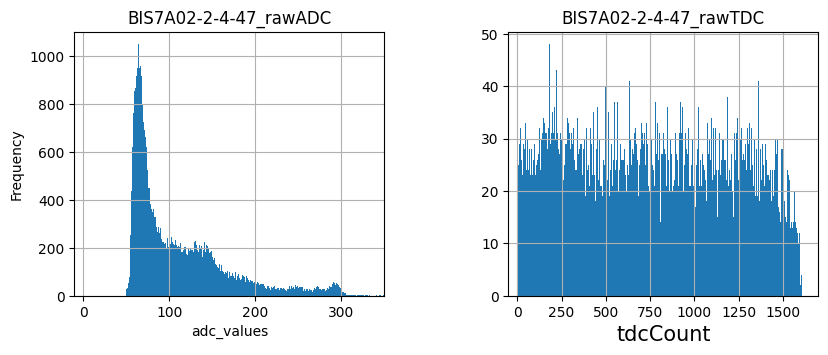

In [64]:
df_adcCut_most_nt=df_adcCut[df_adcCut['rawMdt_tubeInfo']>=most_noisy_tube]
RawMdtplots(df_adcCut_most_nt,most_noisy_tube) #Plots the ADC and TDC spectrum for the most noisy tube affter adc cut

In [59]:
#Plot 2D histogram noise rate vs tube id using df_all(before adc cut)
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist2d(df_noise_rate['Tube_ID'],df_noise_rate['Noise_rate'], bins=60)  # Create a histogram
plt.xlabel('Tube ID')  # Set the x-axis label
plt.ylabel('Noise rate')  # Set the y-axis label
plt.title('2D Histogram Noise rate v/s Tube Id')  # Set the title
plt.grid(False)  # Show grid
# plt.tight_layout()  # Adjust layout
plt.show()

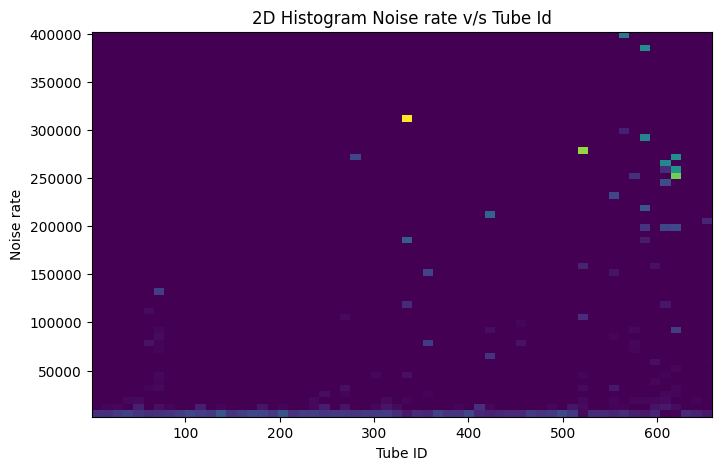

In [60]:
#Plot 2D histogram noise rate vs tube id using df_adcCut
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist2d(df_adcCut['Tube_ID'],df_adcCut['Noise_rate'], bins=60)  # Create a histogram
plt.xlabel('Tube ID')  # Set the x-axis label
plt.ylabel('Noise rate')  # Set the y-axis label
plt.title('2D Histogram Noise rate v/s Tube Id')  # Set the title
plt.grid(False)  # Show grid
# plt.tight_layout()  # Adjust layout
plt.show()

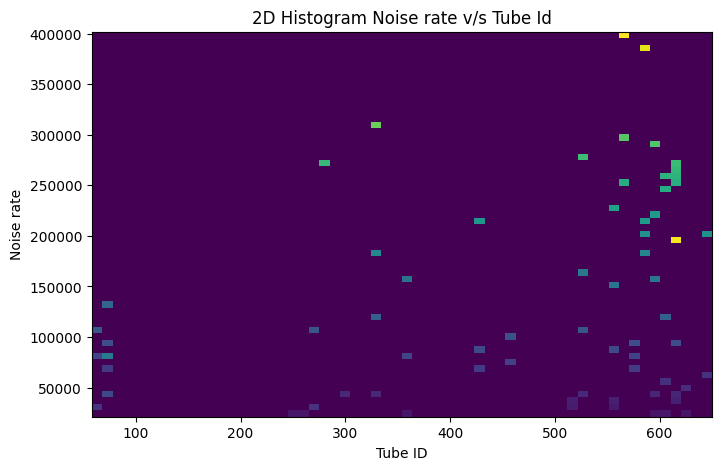

In [61]:
#Plot 2D histogram noise rate vs tube id using df_nt
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist2d(df_for_nt['Tube_ID'],df_for_nt['Noise_rate'], bins=60)  # Create a histogram
plt.xlabel('Tube ID')  # Set the x-axis label
plt.ylabel('Noise rate')  # Set the y-axis label
plt.title('2D Histogram Noise rate v/s Tube Id')  # Set the title
plt.grid(False)  # Show grid
# plt.tight_layout()  # Adjust layout
plt.show()

In [51]:
df_noise_rate

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 35   4307.955078   1780.171753   6535.729980   
      1                 37   4307.567871   1780.585693   6339.417480   
      2                 35   4307.538086   1780.617432   6324.316406   
      3                 67   4307.508301   1780.649292   6309.215820   
      4                 35   4307.478516   1780.681152   6294.114746   
...                    ...           ...           ...           ...   
27970 23                35   4230.391602   1746.779175   6898.238281   
      24                35   4230.391602   1746.779175   6898.238281   
      25               228   4228.784668   1748.498291   6082.786621   
      26                36   4228.188965   1749.135132   5780.767578   
      27               157   4192.552734   1733.373657   6090.376953   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649653           151         839  BIS7A02-2-4-54   
      1          24649640           151         956  BIS7A02-2-4-41   
      2          24649639           151         835  BIS7A02-2-4-40   
      3          24649638           151         717  BIS7A02-2-4-39   
      4          24649637           151         607  BIS7A02-2-4-38   
...                   ...           ...         ...             ...   
27970 23         24649165           218         214  BIS7A02-1-4-78   
      24         24649165           218        1555  BIS7A02-1-4-78   
      25         24649111           218          95  BIS7A02-1-4-24   
      26         24649091           218        1067   BIS7A02-1-4-4   
      27         24648728           218          26  BIS7A02-1-1-25   

               rawMdt_station rawMdt_type  Tube_ID  Tube_hits     Noise_rate  
entry subentry                                                                
0     0               BIS7A02         BIS      606       9379  257931.979000  
      1               BIS7A02         BIS      593       5762  158460.823435  
      2               BIS7A02         BIS      592       8044  221218.129766  
      3               BIS7A02         BIS      591      10612  291840.725147  
      4               BIS7A02         BIS      590       7831  215360.414495  
...                       ...         ...      ...        ...            ...  
27970 23              BIS7A02         BIS      276       9812  269839.916617  
      24              BIS7A02         BIS      276       9812  269839.916617  
      25              BIS7A02         BIS      222        188    5170.190004  
      26              BIS7A02         BIS      202        141    3877.642503  
      27              BIS7A02         BIS       25        179    4922.680909  

[480445 rows x 13 columns]

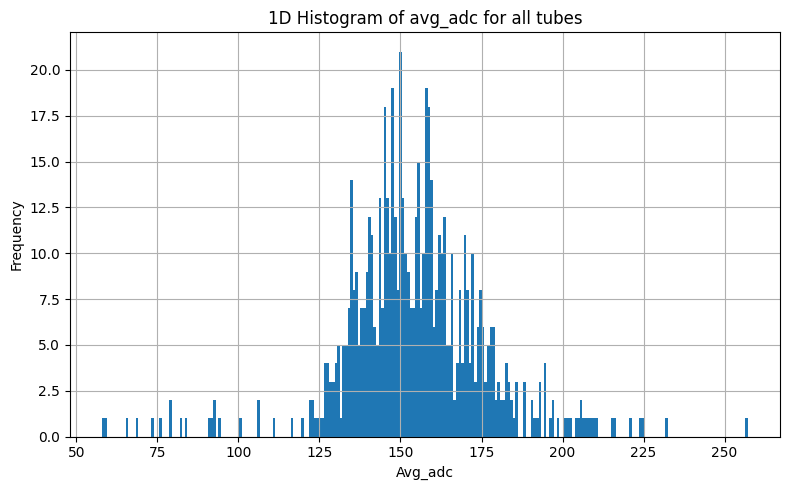

In [11]:
# Plot 1D histogarm AverageADC and 2D histogram AverageADC vs TubeId by using df_adcCut

#plot mean adc for all tubes
#group by tubeInfo and calculate mean adc
# df_adcCut['Mean_adc']=df_adcCut.groupby('rawMdt_tubeInfo')['rawMdt_adc'].transform('mean')




mean_adc=df_mean_adc['Mean_adc']
tube_id=df_mean_adc['Tube_ID']
min_adc = 50
max_adc = 300

plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(mean_adc, bins=max_adc-min_adc)  # Create a histogram with 20 bins
plt.xlabel('Avg_adc')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.title('1D Histogram of avg_adc for all tubes')  # Set the title
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()

                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     14               156   4294.518555   1776.584106   5848.649414   
1     5                209   4308.758301   1779.312134   6943.456055   
      6                129   4308.728516   1779.343994   6928.354980   
      7                166   4308.460938   1779.630493   6792.446289   
      20               176   4296.631348   1774.323608   6920.817383   
...                    ...           ...           ...           ...   
27970 15                68   4296.839844   1774.100830   7026.524414   
      16               116   4296.780273   1774.164429   6996.322266   
      19               159   4294.994629   1776.074707   6090.265137   
      25               228   4228.784668   1748.498291   6082.786621   
      27               157   4192.552734   1733.373657   6090.376953   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tube

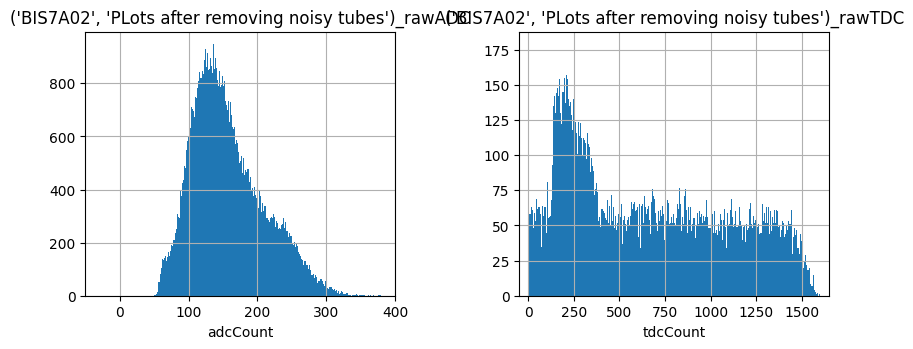

In [79]:
df_raw_removeNoisyTubes = df_adcCut[~df_adcCut['rawMdt_tubeInfo'].isin(noisy_tubes_list)]
print(df_raw_removeNoisyTubes)
plots(df_raw_removeNoisyTubes, OPERATING_CHAMBER, 'PLots after removing noisy tubes')

In [12]:
plt.figure(figsize=(10, 6)) 
plt.hist2d(mean_adc,bins=50)  
plt.xlabel('Avg_adc')  
plt.ylabel('Tube_id')
plt.title('2D Histogram of avg_adc vs Tube ID for all tubes') 
plt.grid(True)  
plt.tight_layout()  
# plt.show()

SyntaxError: invalid syntax (497701728.py, line 2)

In [66]:
# Get the tube list by using cut AverageADC < 100
df_mean_adc_cut=df_mean_adc[df_mean_adc['Mean_adc']<100]
df_mean_adc_cut.sort_values(by=['Mean_adc'])  #lowest avg_adc=58.00, tube_id=553


Tube_ID   Mean_adc
551      553  58.000000
565      568  59.473316
598      601  65.960523
539      541  68.813665
632      635  73.198686
635      638  75.954397
509      511  79.253283
347      349  79.351792
564      567  82.265162
317      319  84.038462
636      639  90.729258
634      637  91.630435
555      558  92.531863
58        59  92.769492
274      275  94.000000

In [91]:
# Plot the ADC and TDC for the lowest AverageADC tube
df_adcCut_tube=df_adcCut[df_adcCut['Tube_ID']==601]
df_adcCut_tube

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
2     8                 69   4307.936035  -1790.133789   6643.427246   
6     13                65   4307.936035  -1790.133789   6643.427246   
15    6                 71   4307.936035  -1790.133789   6643.427246   
20    1                 59   4307.936035  -1790.133789   6643.427246   
23    8                108   4307.936035  -1790.133789   6643.427246   
...                    ...           ...           ...           ...   
26808 11                67   4307.936035  -1790.133789   6643.427246   
26811 2                 64   4307.936035  -1790.133789   6643.427246   
26815 0                 55   4307.936035  -1790.133789   6643.427246   
26822 0                 53   4307.936035  -1790.133789   6643.427246   
26828 0                 56   4307.936035  -1790.133789   6643.427246   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
2     8          24706992           138         402  BIS7A16-2-4-49   
6     13         24706992           120        1075  BIS7A16-2-4-49   
15    6          24706992           123         727  BIS7A16-2-4-49   
20    1          24706992            68         354  BIS7A16-2-4-49   
23    8          24706992           204         230  BIS7A16-2-4-49   
...                   ...           ...         ...             ...   
26808 11         24706992            94         274  BIS7A16-2-4-49   
26811 2          24706992           156         438  BIS7A16-2-4-49   
26815 0          24706992            48         909  BIS7A16-2-4-49   
26822 0          24706992            83         732  BIS7A16-2-4-49   
26828 0          24706992            65        1213  BIS7A16-2-4-49   

               rawMdt_station rawMdt_type  Tube_ID  Tube_hits    Noise_rate  
entry subentry                                                               
2     8               BIS7A16         BIS      601      17064  488760.56919  
6     13              BIS7A16         BIS      601      17064  488760.56919  
15    6               BIS7A16         BIS      601      17064  488760.56919  
20    1               BIS7A16         BIS      601      17064  488760.56919  
23    8               BIS7A16         BIS      601      17064  488760.56919  
...                       ...         ...      ...        ...           ...  
26808 11              BIS7A16         BIS      601      17064  488760.56919  
26811 2               BIS7A16         BIS      601      17064  488760.56919  
26815 0               BIS7A16         BIS      601      17064  488760.56919  
26822 0               BIS7A16         BIS      601      17064  488760.56919  
26828 0               BIS7A16         BIS      601      17064  488760.56919  

[3977 rows x 13 columns]

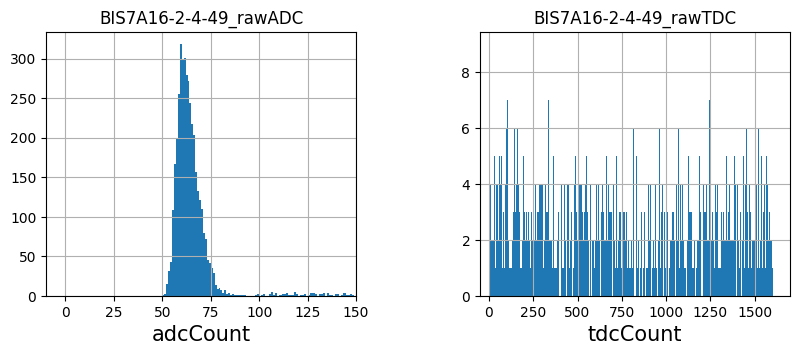

In [92]:
RawMdtplots(df_adcCut_tube,'BIS7A16-2-4-49')

In [97]:
RawMdtplots(df_adcCut,'BIS7A16-1-1-9')

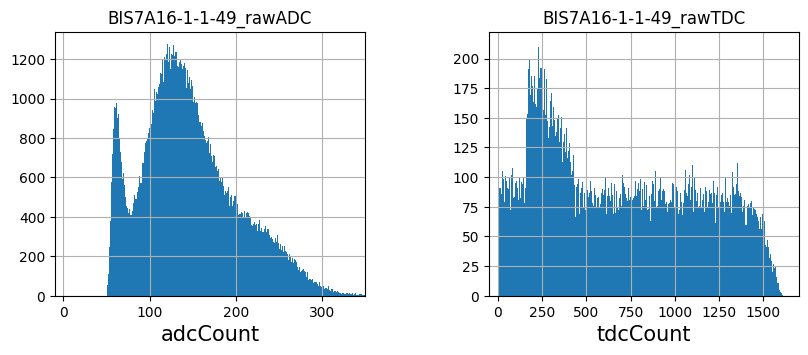

In [100]:
RawMdtplots(df_adcCut,'BIS7A16-1-1-49')